# GA Capstone: Topic Modelling on AMD vs Nvidia GPU

## Contents
- Data Extraction
- Data Cleaning
- [EDA](#EDA)
- [Prepare data for LDA modeling](#Prepare-reddit-comments-for-LDA-modeling)
- [Phrase modeling: Bigram and Trigram models](#Phrase-modeling:-Bigram-and-Trigram-models)
- [LDA Model Training](#LDA-Model-Training)
- Model creation
- Model Evaluation

# Import the libraries

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
import os

import re
# NLTK Library
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Import PRAW package
import praw
from praw.models import MoreComments

# Gensim library
import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaMulticore, CoherenceModel, Phrases
from gensim.models.phrases import Phraser
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora

# pyLDAvis library
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Detect non-english words
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Detect non-english words using spacy
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)


# Import the wordcloud library
from wordcloud import WordCloud

# Removes depreciation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
# Set the max rows and columns for Pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [3]:
# Set the style use
plt.style.use('ggplot')

## Create a helper function to scrap the dataset in reddit

In [4]:
# Create a dictionary with keys as the text and the value being reddit submission id 
nvidia_gpu_sub_dict = {'rtx_3060ti': 'k4mctp', 'rtx_3070':'jj8k0l', 
                       'rtx_3080': 'itw87x', 'rtx_3090': 'iyy5sx', 'rtx_3000': 'iko4ir'}
amd_gpu_sub_dict = {'amd_gpu': 'iknr7g', 'rx_6000_rdna2':'jjq6v1', 'rx_6000_nov_18':'jvxm8z', 'radeon_rx_6000':'jwesyt'} 

In [5]:
# Additional nvidia comments scrapped
add_nvidia_gpu_sub_dict = {'rtx_3090vs3080vs3070': 'ioyjk6', 'scalper_warning': 'ivi4qm', 'rtx_3090_memory': 'igw0bg',
                          'rtx_3080ti_priced': 'jrmtmx', 'rtx_3080_3090_leak': 'ii6179'}

In [6]:
 reddit = praw.Reddit(
     client_id="IR7Y4cUBrVAbGg",
     client_secret="podr43kzztn_CoVgtNQiNpDfjI5mjg",
     user_agent="gpu_scrapper_32",
     username="leader2345",
     password="rPLHgrS8"
 )

In [7]:
def scrapeGPUComment(gpu_dict):
    for key, value in gpu_dict.items():
        # Creates the GPU list to hold the reddit comments
        gpu_lst = []
        # Creating the submission object for rtx megathreads
        submission = reddit.submission(id=value)
        
        # Extract all the commments
        submission.comments.replace_more(limit=None)
        for comment in submission.comments.list():
            gpu_lst.append(comment.body)
        # Converted to Dataframe format
        rtx_df = pd.DataFrame({'Reddit comments':gpu_lst})
        # Creating the column for tags, the keys of the dictionary will be stored here
        rtx_df['tag'] = key
        # Export the individual submissions to csv file
        rtx_df.to_csv('./reddit dataset/' + key + '.csv', index=False)

In [8]:
# Scrapping of nvidia commments
# scrapeGPUComment(nvidia_gpu_sub_dict)

In [9]:
# Scrapping of amd commments
# scrapeGPUComment(amd_gpu_sub_dict)

In [10]:
# Scrapping of additional nvidia commments
# scrapeGPUComment(add_nvidia_gpu_sub_dict)

In [11]:
# Read in the dataframes

# Nvidia's comments
rtx_3000 = pd.read_csv('./reddit dataset/rtx_3000.csv')
rtx_3060ti = pd.read_csv('./reddit dataset/rtx_3060ti.csv')
rtx_3070 = pd.read_csv('./reddit dataset/rtx_3070.csv')
rtx_3080 = pd.read_csv('./reddit dataset/rtx_3080.csv')
rtx_3090 = pd.read_csv('./reddit dataset/rtx_3090.csv')

# Amd's comments
amd_gpu = pd.read_csv('./reddit dataset/amd_gpu.csv')
rx_6000 = pd.read_csv('./reddit dataset/radeon_rx_6000.csv')
rx_6000_nov_18 = pd.read_csv('./reddit dataset/rx_6000_nov_18.csv')
rx_6000_rdna2 = pd.read_csv('./reddit dataset/rx_6000_rdna2.csv')

# Additional Nvidia's comments scrapped
rtx_3090vs3080vs3070 = pd.read_csv('./reddit dataset/rtx_3090vs3080vs3070.csv')
scalper_warning = pd.read_csv('./reddit dataset/scalper_warning.csv')
rtx_3090_memory = pd.read_csv('./reddit dataset/rtx_3090_memory.csv')
rtx_3080ti_priced = pd.read_csv('./reddit dataset/rtx_3080ti_priced.csv')
rtx_3080_3090_leak = pd.read_csv('./reddit dataset/rtx_3080_3090_leak.csv')

In [12]:
# Concat the dataframes by their rows
combined_df = pd.concat([rtx_3000, rtx_3060ti, rtx_3070, rtx_3080,
                        rtx_3090, amd_gpu, rx_6000, rx_6000_nov_18, rx_6000_rdna2,
                        rtx_3090vs3080vs3070, scalper_warning, rtx_3090_memory, rtx_3080ti_priced, rtx_3080_3090_leak],
                       axis=0, ignore_index = False)

# Data cleaning

## Removing the null values

In [13]:
# Check the dimensions of the data
combined_df.shape

(34534, 2)

In [14]:
# Checking for null values
combined_df.isnull().sum()

Reddit comments    3
tag                0
dtype: int64

In [15]:
# Check for null values
combined_df.dropna(inplace = True)

In [16]:
# Checking for null values
combined_df.isnull().sum()

Reddit comments    0
tag                0
dtype: int64

## Dropping comments with `[deleted]` and `[removed]` in them

In [17]:
combined_df.shape

(34531, 2)

In [18]:
removed_deleted_comments_idx = combined_df[(combined_df['Reddit comments'] == '[removed]') | (combined_df['Reddit comments'] == '[deleted]')].index
removed_deleted_comments_idx

Int64Index([  46,   56,   57,   82,   83,  118,  150,  157,  160,  244,
            ...
            2240, 2321, 2343, 2348, 2350, 2364, 2407, 2422, 2425, 2436],
           dtype='int64', length=778)

A total of 778 comments will be dropped from the dataframe.

In [19]:
# Drop the deleted and removed comments
combined_df.drop(removed_deleted_comments_idx, axis=0, inplace = True)

In [20]:
combined_df.shape

(28809, 2)

## Cleaning the Reddit comments

In [21]:
# Full function to clean the title and the post
def clean_post(df):
    """
    This function removes the unnecessary characters, punctuations, removes stop words and lemmantizes the words
    from the posts and titles. Lemmantization is used as I want to preserve the meaning of the words in which it'll compare the words against a dictionary.
    """
    new_lst = []
    
    # Stop words
    stop_words = set(STOPWORDS).union(stopwords.words("english")) # Combines gensim stopwords and nltk's stopwords
    stop_words = stop_words.union(['http', 'www', 'youtube' 'get', 'like'])
    
    # Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    for post in df:
        # Lowercase the text
        post = post.lower()

        # Find the https websites and removes them
        post = re.sub(r'http\S+','',post)

        # Removes youtube links
        #post = re.sub('https:.*?\\n','',post)

        # Removes uncaptured url links at the bottom of the text
        post = re.sub('https.*?[\\n|"]','',post)

        # Removes characters: \n\n&amp;#x200B;
        post = re.sub('\\n\\n&amp;#x200b;\\n\\n','',post)

        # Removing the special characters, like punctuation marks, periods
        post = re.sub(r'[^\w]',' ',post)
        
        # Removes digits and keeps the letters
        # post = re.sub(r'[^a-zA-Z]', ' ', post)

        # Removes underscores
        post = re.sub(' _', ' ',post)

        # Removes addtional white spaces
        post = re.sub(' +', ' ',post)
        
        # Stores the words in a list 
        lst = [lemmatizer.lemmatize(word) for word in post.split() if not word in stop_words]
            
        new_lst.append(" ".join(lst))
        
    return new_lst

In [22]:
# Cleans the Reddit comments column
combined_df['Reddit comments'] = clean_post(combined_df['Reddit comments'])
combined_df['Reddit comments']

0                           pre order time releasing 17th
2                          going hard grab card 3080 17th
4       uk price 3090 1399 3080 649 3070 469 scan aib ...
5       badly want 3080 especially price concerned 10g...
6                              talking spatula jensen pot
                              ...                        
2433                  motherboard say pcie 3 0 compatible
2434    thanks understanding know course 3000s dvi por...
2435                                         buy 1400 gpu
2437                          lol know ill wait 3070 3060
2438    generational compatibility compatible size pci...
Name: Reddit comments, Length: 28809, dtype: object

In [23]:
# Checking for stop words
combined_df['Reddit comments'][combined_df['Reddit comments'].map(lambda word:'http' in word)].values

array([], dtype=object)

## Dropping comments that are empty

In [24]:
combined_df.describe()

,Reddit comments,tag
count,28809,28809
unique,27736,14
top,,rx_6000_rdna2
freq,290,9869


In [25]:
(combined_df['Reddit comments'] == '').sum()

290

There are 213 empty comments that have to be dropped.

In [26]:
empty_comments_idx = combined_df[combined_df['Reddit comments'] == ''].index
combined_df.drop(empty_comments_idx, axis=0, inplace=True)

In [27]:
(combined_df['Reddit comments'] == '').sum()

0

The empty comments have been removed.

## Setting the tags with either `Nvidia` or `Amd`

In [28]:
combined_df['tag'].unique()

array(['rtx_3000', 'rtx_3060ti', 'rtx_3070', 'rtx_3080', 'rtx_3090',
       'amd_gpu', 'radeon_rx_6000', 'rx_6000_nov_18', 'rx_6000_rdna2',
       'rtx_3090vs3080vs3070', 'scalper_warning', 'rtx_3090_memory',
       'rtx_3080ti_priced', 'rtx_3080_3090_leak'], dtype=object)

These tags need to be renamed to either `Nvidia` or `Amd`

In [29]:
nvidia_tag_lst = list(nvidia_gpu_sub_dict) + list(add_nvidia_gpu_sub_dict)
amd_tag_lst = list(amd_gpu_sub_dict)

In [30]:
print(nvidia_tag_lst)
print(amd_tag_lst)

['rtx_3060ti', 'rtx_3070', 'rtx_3080', 'rtx_3090', 'rtx_3000', 'rtx_3090vs3080vs3070', 'scalper_warning', 'rtx_3090_memory', 'rtx_3080ti_priced', 'rtx_3080_3090_leak']
['amd_gpu', 'rx_6000_rdna2', 'rx_6000_nov_18', 'radeon_rx_6000']


In [31]:
combined_df['tag'].replace(nvidia_tag_lst, ['nvidia' for _ in range(len(nvidia_tag_lst))], inplace = True)
combined_df['tag'].replace(amd_tag_lst, ['amd' for _ in range(len(amd_tag_lst))], inplace = True)

In [32]:
combined_df['tag'].value_counts()

amd       15424
nvidia    11454
Name: tag, dtype: int64

## Removing duplicates in the dataframe

In [33]:
combined_df.duplicated(subset='Reddit comments', keep = False).sum()

1031

In [34]:
combined_df[combined_df.duplicated(subset='Reddit comments', keep = False)]

,Reddit comments,tag
58,pre order,nvidia
130,pre order,nvidia
147,spatula,nvidia
408,scared new mining performance card new memory ...,nvidia
450,3060,nvidia
...,...,...
2069,wait benchmark,nvidia
2131,case,nvidia
2261,think,nvidia
2405,good bot,nvidia


There are 1061 comments that are duplicated and have to be dropped.

In [35]:
combined_df.shape

(26878, 2)

In [36]:
combined_df.drop_duplicates(subset='Reddit comments', keep = False, ignore_index= True, inplace = True)

In [37]:
combined_df.shape

(25847, 2)

In [38]:
combined_df.duplicated(subset='Reddit comments', keep = False).sum()

0

The duplicated comments have been removed.

In [39]:
# Randomly going through the rows to check if it's cleaned properly 
combined_df['Reddit comments'].loc[np.random.randint(1707)]

'lol ing rtx 2080tis 2080s listed ebay'

### Removing non-english words in the reviews (Possible to ignore)

In [40]:
# # Removing non english by creating a helper function
# from langdetect import detect
# def isenglish(text):
#     try:
#         if nlp(text)._.language.get('language') == 'en':
#             return 1
#         else:
#             return 0
#     except:
#         return 0

In [41]:
# GPU_df['isenglish'] = GPU_df['Customer Review'].apply(isenglish)

In [42]:
# GPU_df[GPU_df.loc[:,'isenglish'] == 0][['Customer Review']].head(10)

In [43]:
# Count number of rows with the string deleted in them
# GPU_df['Customer Review'].map(lambda x: x.count('deleted')).sum()

In [44]:
# GPU_df[GPU_df.loc[:,'isenglish'] == 0][['Customer Review']].count()

A total of 130 rows were non-english reviews. These have to be removed.

## Exporting the cleaned csv file 

In [45]:
# Save to csv file
combined_df.to_csv('./reddit dataset/cleaned_combined_df.csv', index=False)

# EDA on the comments

In [46]:
# Read the existing csv file
GPU_df = pd.read_csv('./reddit dataset/cleaned_combined_df.csv')
GPU_df

,Reddit comments,tag
0,pre order time releasing 17th,nvidia
1,going hard grab card 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,talking spatula jensen pot,nvidia
4,10k core completely insane,nvidia
...,...,...
25842,motherboard say pcie 3 0 compatible,nvidia
25843,thanks understanding know course 3000s dvi por...,nvidia
25844,buy 1400 gpu,nvidia
25845,lol know ill wait 3070 3060,nvidia


In [47]:
GPU_df.describe()

,Reddit comments,tag
count,25847,25847
unique,25847,2
top,sub filled nvidia shill,amd
freq,1,14695


In [48]:
GPU_df.shape

(25847, 2)

In [49]:
# Check for null values
GPU_df.isnull().sum()

Reddit comments    0
tag                0
dtype: int64

In [50]:
# Checking for duplicated comments
GPU_df.duplicated(subset='Reddit comments', keep=False).sum()

0

## Distribution of AMD and Nvidia comments

In [51]:
GPU_df['tag'].value_counts(normalize=True) * 100

amd       56.853793
nvidia    43.146207
Name: tag, dtype: float64

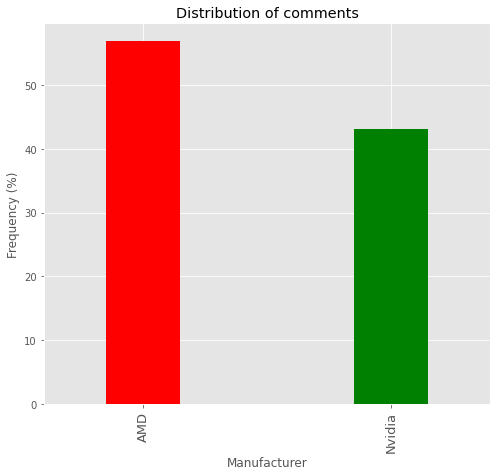

In [52]:
(GPU_df['tag'].value_counts(normalize=True) * 100).plot(kind='bar', 
                                                        title='Distribution of comments',
                                                        figsize=(8,7),
                                                        xlabel = 'Manufacturer',
                                                       ylabel='Frequency (%)',
                                                       color = ['red','green'],
                                                       width=0.3)

plt.xticks(np.arange(2), ['AMD', 'Nvidia'],fontsize=13);

In the dataset, around 56% of the comments were from AMD and the Hardware subreddit and 43% of the comments were from Nvidia's subreddit.

## EDA on Amd comments

In [53]:
# Obtaining only AMD comments
amd_df = GPU_df[GPU_df['tag'] == 'amd']
amd_df

,Reddit comments,tag
4756,sound samsung 8nm cheap,amd
4757,ethic mongol invasion tech,amd
4758,nvidia software ai learning big selling point,amd
4759,excited amd guy compete going nvidia brand loy...,amd
4760,think nvidia actualy competing new console pri...,amd
...,...,...
19446,dude understand example confused said looked r...,amd
19447,know example thought looked,amd
19448,probably score higher english proficiency test...,amd
19449,prove know concept cost opportunity efficiency...,amd


### Distribution of text for AMD comments

In [54]:
# Obtain the length of of each post and store the values in length
textlength = amd_df['Reddit comments'].apply(lambda x:len(x.split())).rename('textlength')
textlength

4756      4
4757      4
4758      7
4759      9
4760     12
         ..
19446     9
19447     4
19448     8
19449    12
19450    16
Name: textlength, Length: 14695, dtype: int64

In [55]:
amd_df = pd.concat([amd_df, textlength], axis=1)
amd_df

,Reddit comments,tag,textlength
4756,sound samsung 8nm cheap,amd,4
4757,ethic mongol invasion tech,amd,4
4758,nvidia software ai learning big selling point,amd,7
4759,excited amd guy compete going nvidia brand loy...,amd,9
4760,think nvidia actualy competing new console pri...,amd,12
...,...,...,...
19446,dude understand example confused said looked r...,amd,9
19447,know example thought looked,amd,4
19448,probably score higher english proficiency test...,amd,8
19449,prove know concept cost opportunity efficiency...,amd,12


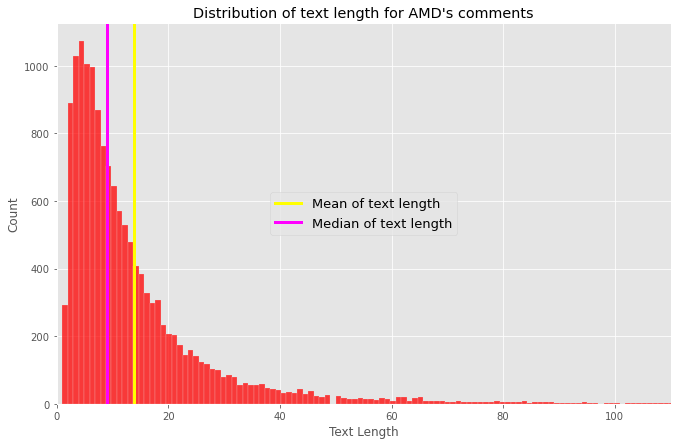

In [56]:
# Plotting the histogram of the textlength
plt.figure(figsize=(11,7))
sns.histplot(amd_df['textlength'], color='red')

plt.title("Distribution of text length for AMD's comments")

# Plot the mean of the distribution
plt.axvline(amd_df['textlength'].mean(), color='yellow', linewidth=3, label = 'Mean of text length')
plt.axvline(amd_df['textlength'].median(), color='magenta', linewidth=3, label = 'Median of text length')

plt.xlabel('Text Length')
plt.legend(fontsize=13, loc='center')
plt.xlim(0,110);

In [57]:
print(f"Mean of AMD's text length is {amd_df['textlength'].mean()}.")
print(f"Median of AMD's text length is {amd_df['textlength'].median()}.")

Mean of AMD's text length is 13.890575025518883.
Median of AMD's text length is 9.0.


The distribution shows a right tailed histogram with posts length having a mean of 15 and a median of 10.

### Frequently occurring words in AMD comments 

In [58]:
# Obtaining the frequency of the tokens
amd_comments_lst = list(" ".join(amd_df['Reddit comments']).split())
amd_comments_dict = {}

# Creates a frequency dictionary
for word in amd_comments_lst:
    if word not in amd_comments_dict.keys():
        amd_comments_dict[word] = amd_comments_lst.count(word)
    else:
        continue
        
amd_comments_dict

{'sound': 124,
 'samsung': 110,
 '8nm': 57,
 'cheap': 94,
 'ethic': 3,
 'mongol': 14,
 'invasion': 3,
 'tech': 193,
 'nvidia': 2599,
 'software': 231,
 'ai': 114,
 'learning': 50,
 'big': 451,
 'selling': 112,
 'point': 506,
 'excited': 57,
 'amd': 3666,
 'guy': 177,
 'compete': 256,
 'going': 902,
 'brand': 82,
 'loyalty': 20,
 'sucker': 12,
 'think': 1154,
 'actualy': 1,
 'competing': 70,
 'new': 750,
 'console': 506,
 'price': 1682,
 '499': 93,
 '2080ti': 411,
 'performance': 2106,
 'dumping': 1,
 'reputable': 6,
 'leak': 64,
 'rdna2': 190,
 'say': 97,
 '40': 62,
 '50': 374,
 'faster': 383,
 'couple': 99,
 'rumored': 23,
 'focus': 30,
 'power': 475,
 'efficiency': 63,
 'advantage': 120,
 'tsmc': 116,
 'process': 74,
 '7nm': 108,
 'forget': 55,
 'silicon': 29,
 'pushed': 28,
 '350': 59,
 'tdp': 53,
 'impossible': 25,
 'raise': 26,
 'coming': 196,
 'competitive': 176,
 'want': 710,
 'buy': 744,
 'potentially': 18,
 'lower': 355,
 'waiting': 219,
 'im': 159,
 'sure': 548,
 'good': 987,

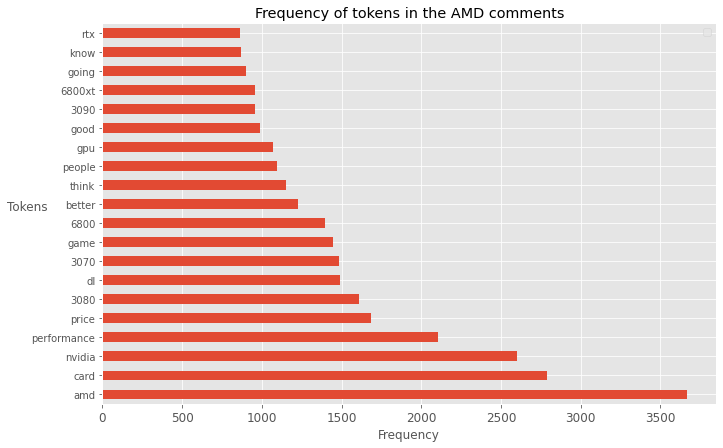

In [59]:
amd_freq_df = pd.DataFrame({'words': amd_comments_dict.keys(), 'freq': amd_comments_dict.values()})
amd_freq_df.sort_values('freq', ascending=False).set_index('words').head(20).plot(kind='barh', figsize=(11,7),
                                                                                          title='Frequency of tokens in the AMD comments')

plt.xlabel('Frequency')
plt.ylabel('Tokens', rotation=360)
plt.xticks(fontsize=12)
plt.legend([]);

Other than `amd`, `nvidia` and `card`, it seems that the most commonly occuring words are `performance`, `price`, Nvidia's GPU models the Rtx [`3080`](https://www.nvidia.com/en-sg/geforce/graphics-cards/30-series/rtx-3080/), Rtx [`3070`](https://www.nvidia.com/en-sg/geforce/graphics-cards/30-series/rtx-3070/) and AMD's [`6800`](https://www.amd.com/en/products/graphics/amd-radeon-rx-6800). These type of GPUs are catered towards enthusiast grade gamers who play in resolutions of 1440p and upwards and at frames above 60. The `dl` likely refers to Nvidia's DLSS (Deep Learning Super Sampling) which uses the Tensor core AI processors on the GPU to boost frame rates and render beautiful and sharp images in games. Surprisingly, only one AMD model, the 6800, made it to the top frequent tokens list, which highlights the popularity behind Nvidia's cards. 

### Word cloud on AMD's comments

In [60]:
amd_string = " ".join(amd_df['Reddit comments'])

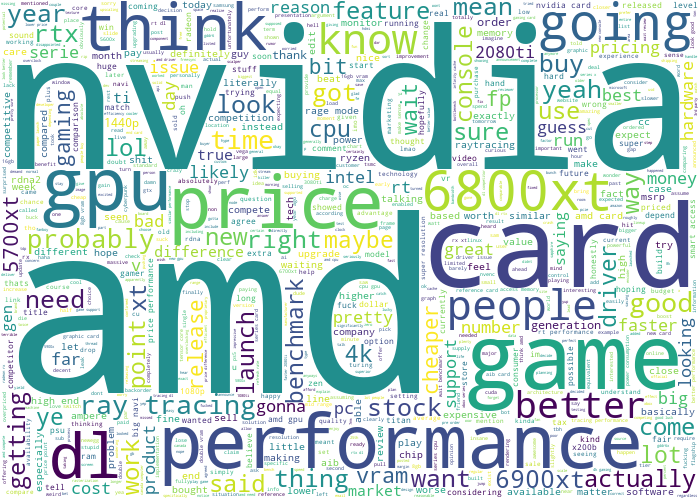

In [61]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=5, contour_color='steelblue', width=700, height=500)
wordcloud.generate(amd_string)
# Visualize the word cloud
wordcloud.to_image()

These tokens look similar to the frequency distribution graph that was created previously.

### Longest AMD comment

In [62]:
amd_df.sort_values(by='textlength', ascending=False).iloc[0].values

array(['example ray tracing insanely computationally expensive push higher higher resolution jumping 1080p 1440p 4k adding big load gpus ray tracing exacerbates essentially enabling ray tracing half performance huge performance hit think agree 1 exactly dl important negates halving ray tracing 2 guarantee devs away completely fake baking lighting cube map use rtx know long way away unfortunately yes computationally expensive far easier devs implement physic based work box hundred hour cube map hit generally getting ray tracing effect certain area example ray traced environmental lighting effect muzzle trade lighting option severe performance penalty yep absolute best implementation control far good cyberpunk implementation albeit bet extremely good given close partnership nvidia said implementation computational cost high best cast 1 2 ray pixel enormously far realistic rendering theoretically say need cast 500 ray pixel simulate true 1 2 ray pixel extremely obvious ray tracing active 

The comments talks about ray tracing, which is a feature exclusive to Nvidia which provides realistic lighting in games, that is found to be computationally expensive and causes performance to drop significantly for the previous generation of GPUs, the Rtx 2000 series. But the newly released RTX 3000 series provides better performance using ray tracing.

## EDA on Nvidia comments

In [63]:
# Obtaining only AMD comments
nvidia_df = GPU_df[GPU_df['tag'] == 'nvidia']
nvidia_df

,Reddit comments,tag
0,pre order time releasing 17th,nvidia
1,going hard grab card 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,talking spatula jensen pot,nvidia
4,10k core completely insane,nvidia
...,...,...
25842,motherboard say pcie 3 0 compatible,nvidia
25843,thanks understanding know course 3000s dvi por...,nvidia
25844,buy 1400 gpu,nvidia
25845,lol know ill wait 3070 3060,nvidia


### Distribution of text for AMD comments

In [64]:
# Obtain the length of of each post and store the values in length
textlength = nvidia_df['Reddit comments'].apply(lambda x:len(x.split())).rename('textlength')
textlength

0         5
1         6
2        18
3         4
4         4
         ..
25842     6
25843    87
25844     3
25845     6
25846    26
Name: textlength, Length: 11152, dtype: int64

In [65]:
nvidia_df = pd.concat([nvidia_df, textlength], axis=1)
nvidia_df

,Reddit comments,tag,textlength
0,pre order time releasing 17th,nvidia,5
1,going hard grab card 3080 17th,nvidia,6
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia,18
3,talking spatula jensen pot,nvidia,4
4,10k core completely insane,nvidia,4
...,...,...,...
25842,motherboard say pcie 3 0 compatible,nvidia,6
25843,thanks understanding know course 3000s dvi por...,nvidia,87
25844,buy 1400 gpu,nvidia,3
25845,lol know ill wait 3070 3060,nvidia,6


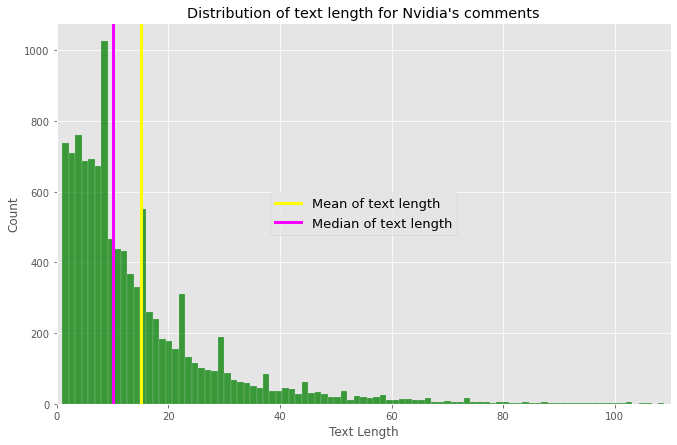

In [66]:
# Plotting the histogram of the textlength
plt.figure(figsize=(11,7))
sns.histplot(nvidia_df['textlength'], color='green')

plt.title("Distribution of text length for Nvidia's comments")

# Plot the mean of the distribution
plt.axvline(nvidia_df['textlength'].mean(), color='yellow', linewidth=3, label = 'Mean of text length')
plt.axvline(nvidia_df['textlength'].median(), color='magenta', linewidth=3, label = 'Median of text length')

plt.xlabel('Text Length')
plt.legend(fontsize=13, loc='center')
plt.xlim(0,110);

In [67]:
print(f"Mean of Nvidia's text length is {nvidia_df['textlength'].mean()}")
print(f"Median of Nvidia's text length is {nvidia_df['textlength'].median()}")

Mean of Nvidia's text length is 15.151093974175035
Median of Nvidia's text length is 10.0


Similar to the text length of AMD's comments dataframe, it shows a right skewed histogram with the text length for Nvidia's comment has a mean of 17 and median of 12 which are slightly higher compared to AMD's comments.

## Frequently occurring words in Nvidia's comments

In [68]:
# Obtaining the frequency of the tokens
nvidia_comments_lst = list(" ".join(nvidia_df['Reddit comments']).split())
nvidia_comments_dict = {}

In [69]:
# Creates a frequency dictionary
for word in nvidia_comments_lst:
    if word not in nvidia_comments_dict.keys():
        nvidia_comments_dict[word] = nvidia_comments_lst.count(word)
    else:
        continue
        
nvidia_comments_dict

{'pre': 92,
 'order': 183,
 'time': 875,
 'releasing': 48,
 '17th': 62,
 'going': 893,
 'hard': 169,
 'grab': 36,
 'card': 2661,
 '3080': 2247,
 'uk': 64,
 'price': 1223,
 '3090': 1677,
 '1399': 11,
 '649': 12,
 '3070': 705,
 '469': 3,
 'scan': 24,
 'aib': 211,
 'thanks': 186,
 'u': 53,
 'benzyl': 1,
 'chloride': 1,
 'overclockers': 17,
 'talking': 137,
 'spatula': 3,
 'jensen': 32,
 'pot': 1,
 '10k': 18,
 'core': 336,
 'completely': 63,
 'insane': 81,
 'rip': 27,
 '2080': 558,
 'ti': 862,
 'resale': 17,
 'value': 168,
 'x200b': 91,
 'cry': 24,
 'shit': 208,
 'actually': 433,
 'better': 640,
 'people': 1141,
 'expected': 48,
 'expensive': 145,
 'shader': 17,
 'tflop': 4,
 'number': 182,
 'real': 153,
 'world': 95,
 'fp': 6,
 'performance': 1092,
 'holy': 34,
 'fucking': 113,
 'christ': 13,
 'massive': 97,
 'upgrade': 538,
 'beating': 15,
 'pascal': 57,
 'send': 25,
 'money': 432,
 'question': 135,
 'nvidia': 1164,
 '3xxx': 6,
 'series': 564,
 'page': 61,
 'reporting': 6,
 'exactly': 11

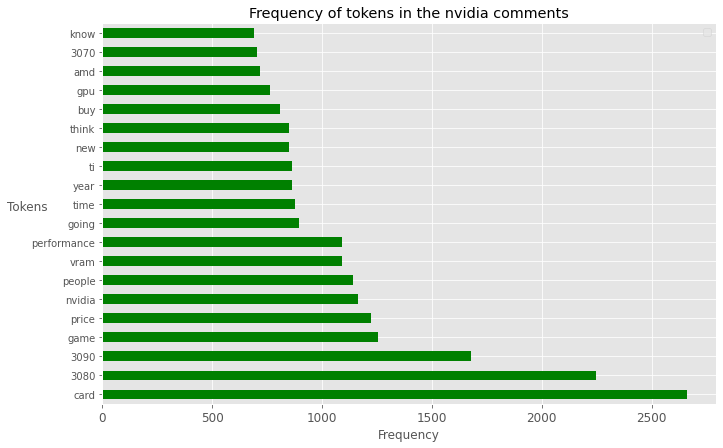

In [70]:
nvidia_freq_df = pd.DataFrame({'words': nvidia_comments_dict.keys(), 'freq': nvidia_comments_dict.values()})
nvidia_freq_df.sort_values('freq', ascending=False).set_index('words').head(20).plot(kind='barh', figsize=(11,7),
                                                                                          color = 'green',
                                                                                          title='Frequency of tokens in the nvidia comments')

plt.xlabel('Frequency')
plt.ylabel('Tokens', rotation=360)
plt.xticks(fontsize=12)
plt.legend([]);

Tokens that were found in AMD's comments are also are found in Nvidia's most frequent tokens, tokens such as `3080`, `card`, `game`, `performance`. Nvidia's RTX 3080 GPU model seems to be the popular among gamers as it was found in both AMD's and Nvidia's comments. The consumers are `price` and `performance` driven given these tokens appear in both subreddits and it attracts gamers given the word `game` has occurred in both the subreddits. `vram`, known as video ram, seems to play an important feature when purchasing video cards as it helps to shorten loading times and improving image quality. Certain levels of VRAM are necessary for games to run at different resolutions. For example, rendering a game at 1080p resolution is different than rendering a game at 4K resolution, which requires more graphics memory.

### Word cloud on Nvidia's comments

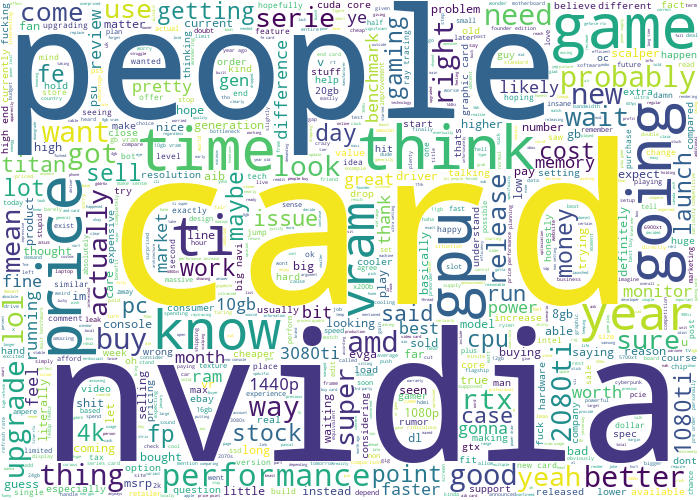

In [71]:
# Word cloud on Nvi's comments
nvidia_string = " ".join(nvidia_df['Reddit comments'])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=5, contour_color='steelblue', width=700, height=500)
wordcloud.generate(nvidia_string)

# Visualize the word cloud
wordcloud.to_image()

The graph shows consistency with the word cloud on the frequency of the words appearing in Nvidia's comments.

# Prepare comments for modeling

In [72]:
# Creates the bag of words for each document
data = [token.split() for token in amd_df['Reddit comments'].tolist()]

In [73]:
# Prints the bag of words from the first 3 documents
print(data[:3])

[['sound', 'samsung', '8nm', 'cheap'], ['ethic', 'mongol', 'invasion', 'tech'], ['nvidia', 'software', 'ai', 'learning', 'big', 'selling', 'point']]


## Phrase modeling: Bigram and Trigram models

In [74]:
# Build the bigram and trigram models
bigram = Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram, this reduces memory, making the model smaller and faster
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [75]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_bigrams = make_bigrams(data)

# Form Trigrams
data_trigrams = make_trigrams(data)

### Stuff to consider

1) Need to decide whether to use parts of speech tag on the reddit comments

## LDA on AMD comments with unigrams

In [76]:
# Create Dictionary
id2word = corpora.Dictionary(data)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data]

# (token, token_id)
# print(id2word.token2id)

In [77]:
# View
# (token_id, token_frequency)
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


## LDA Model Training on AMD comments

In [78]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = LdaMulticore(corpus=corpus, 
                         id2word=id2word, 
                         num_topics=num_topics,
                         chunksize=100,
                         passes=20, 
                         random_state=42,
                        per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"dl" + 0.019*"super" + 0.016*"feature" + 0.016*"work" + 0.012*"0" + '
  '0.012*"resolution" + 0.012*"amd" + 0.011*"game" + 0.011*"core" + '
  '0.010*"working"'),
 (1,
  '0.024*"order" + 0.023*"got" + 0.023*"stock" + 0.018*"amd" + 0.013*"day" + '
  '0.012*"cc" + 0.011*"launch" + 0.011*"card" + 0.010*"know" + 0.010*"hope"'),
 (2,
  '0.038*"card" + 0.013*"end" + 0.012*"aib" + 0.010*"year" + 0.010*"reference" '
  '+ 0.010*"die" + 0.009*"chip" + 0.008*"drop" + 0.008*"model" + '
  '0.008*"launch"'),
 (3,
  '0.032*"rage" + 0.029*"mode" + 0.027*"yes" + 0.026*"lol" + 0.022*"6900" + '
  '0.011*"thank" + 0.009*"red" + 0.009*"lmao" + 0.009*"think" + 0.008*"team"'),
 (4,
  '0.027*"game" + 0.027*"ray" + 0.025*"tracing" + 0.022*"nvidia" + 0.022*"amd" '
  '+ 0.013*"console" + 0.011*"dl" + 0.011*"performance" + 0.009*"think" + '
  '0.009*"high"'),
 (5,
  '0.044*"3070" + 0.040*"6800" + 0.027*"3080" + 0.026*"price" + 0.023*"vram" + '
  '0.021*"6800xt" + 0.019*"performance" + 0.016*"4k" + 0.

In [79]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+'ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+ '\\visualization\\' + 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.156542 -0.014534       1        1  18.814027
7     -0.096148 -0.029607       2        1  16.731839
5     -0.185118  0.133327       3        1  14.663675
4     -0.116056 -0.111706       4        1  14.604039
1      0.038279  0.055599       5        1   7.751749
2     -0.026943  0.104883       6        1   7.207218
0      0.001296 -0.274985       7        1   6.801011
6      0.083972  0.167761       8        1   5.382489
8      0.235270  0.029070       9        1   4.388511
3      0.221988 -0.059809      10        1   3.655443, topic_info=       Term         Freq        Total Category  logprob  loglift
100    3070  1409.000000  1409.000000  Default  30.0000  30.0000
398      dl  1503.000000  1503.000000  Default  29.0000  29.0000
5396   6800  1357.000000  1357.000000  Default  28.0000  28.0000
296     cpu   682.000000   682.000000  Default  27.0000  27.0000
328     ray   809.000000   809.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
99    x200b    40.951590   125.113944  Topic10  -5.2051   2.1921
32    think    63.764786  1258.401873  Topic10  -4.7623   0.3266
426    hard    37.526857   138.729728  Topic10  -5.2925   2.0015
406   slide    36.383827    99.824553  Topic10  -5.3234   2.2997
77     need    39.582553   731.232217  Topic10  -5.2391   0.3926

[667 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
429       1  0.195420        0
429       2  0.111669        0
429       4  0.011965        0
429       7  0.677989        0
793       1  0.158877        1
...     ...       ...      ...
4706      7  0.956903  youtube
391       1  0.446288      zen
391       2  0.030992      zen
391       5  0.012397      zen
391       9  0.502074      zen

[1455 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 6, 5, 2, 3, 1, 7, 9, 4])

### Notes on the pyLDAvis bubbles

* Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.

* Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.

* Red bars give the estimated number of times a given term was generated by a given topic. As you can see from the image below, there are about 22,000 of the word ‘go’, and this term is used about 10,000 times within topic 1. The word with the longest red bar is the word that is used the most by the tweets belonging to that topic.

* The further the bubbles are away from each other, the more different they are. For example, it is difficult to tell the difference between topics 1 and 2. They seem to be both about social life, but it is much easier to tell the difference between topics 1 and 3. We can tell that topic 3 is about politics.

A good topic model will have big and non-overlapping bubbles scattered throughout the chart. As we can see from the graph, the bubbles are clustered within one place. Can we do better than this?

## Compute coherence score

In [80]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5180660120267845


## LDA on AMD comments using bigrams

In [81]:
# Create Dictionary
id2word = corpora.Dictionary(data_bigrams)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data]

# (token, token_id)
# print(id2word.token2id)

In [82]:
# View
# (token_id, token_frequency)
print(corpus[:1][0][:30])

[(0, 1), (2, 1), (55, 1), (1674, 1)]


## LDA Model Training on AMD comments

In [83]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = LdaMulticore(corpus=corpus, 
                         id2word=id2word, 
                         num_topics=num_topics,
                         chunksize=100,
                         passes=20, 
                         random_state=42,
                        per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"3090" + 0.034*"6900xt" + 0.029*"card" + 0.021*"gaming" + 0.017*"4k" '
  '+ 0.016*"people" + 0.013*"monitor" + 0.012*"1440p" + 0.011*"high" + '
  '0.010*"time"'),
 (1,
  '0.044*"xt" + 0.034*"6800" + 0.023*"yes" + 0.021*"2" + 0.020*"1" + '
  '0.020*"rx" + 0.013*"5" + 0.012*"6700" + 0.012*"5700" + 0.012*"radeon"'),
 (2,
  '0.014*"good" + 0.014*"year" + 0.012*"console" + 0.011*"new" + 0.011*"gpu" + '
  '0.010*"want" + 0.010*"thing" + 0.010*"game" + 0.010*"pc" + 0.009*"cpu"'),
 (3,
  '0.032*"power" + 0.020*"amd" + 0.014*"think" + 0.012*"big" + 0.012*"navi" + '
  '0.012*"3" + 0.012*"zen" + 0.011*"series" + 0.011*"psu" + 0.011*"card"'),
 (4,
  '0.024*"order" + 0.022*"series" + 0.020*"got" + 0.020*"cpu" + 0.018*"card" + '
  '0.014*"5000" + 0.014*"launch" + 0.013*"smart" + 0.012*"amd" + '
  '0.012*"access"'),
 (5,
  '0.041*"dl" + 0.030*"game" + 0.024*"performance" + 0.022*"ray" + '
  '0.021*"tracing" + 0.015*"rt" + 0.013*"amd" + 0.013*"better" + '
  '0.012*"feature" + 0.012*"rtx"

In [84]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+'ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+ '\\visualization\\' + 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.116373  0.080683       1        1  19.841417
5     -0.153899  0.075239       2        1  17.895346
8     -0.118751 -0.048467       3        1  15.131204
2     -0.076308 -0.067895       4        1   9.267843
0     -0.015335 -0.037056       5        1   7.632609
4      0.109085 -0.176890       6        1   7.528980
3     -0.072192  0.068745       7        1   6.723014
7      0.227566 -0.131531       8        1   6.177846
9     -0.034729 -0.014491       9        1   5.399269
1      0.250936  0.251663      10        1   4.402473, topic_info=           Term         Freq        Total Category  logprob  loglift
393          dl  1489.000000  1489.000000  Default  30.0000  30.0000
5492       6800  1357.000000  1357.000000  Default  29.0000  29.0000
99         3070  1410.000000  1410.000000  Default  28.0000  28.0000
14          amd  3347.000000  3347.000000  Default  27.0000  27.0000
10       nvidia  2429.000000  2429.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
252        wait    63.080362   572.925322  Topic10  -4.9581   0.9167
1217          4    50.477188   202.814654  Topic10  -5.1809   1.7322
2328      heard    40.343851    66.321514  Topic10  -5.4050   2.6259
1183     6800xt    43.979352   939.578436  Topic10  -5.3187   0.0613
344   benchmark    41.033972   567.853585  Topic10  -5.3881   0.4955

[675 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
424       2  0.875186     0
424       3  0.015287     0
424       4  0.045861     0
424       8  0.061148     0
2212     10  0.942563   000
...     ...       ...   ...
733       8  0.010833   yes
733       9  0.097499   yes
733      10  0.549785   yes
1490      7  0.996650   zen
4180      7  0.976956  zen3

[1513 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 9, 3, 1, 5, 4, 8, 10, 2])

### Notes on the pyLDAvis bubbles

* Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.

* Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.

* Red bars give the estimated number of times a given term was generated by a given topic. As you can see from the image below, there are about 22,000 of the word ‘go’, and this term is used about 10,000 times within topic 1. The word with the longest red bar is the word that is used the most by the tweets belonging to that topic.

* The further the bubbles are away from each other, the more different they are. For example, it is difficult to tell the difference between topics 1 and 2. They seem to be both about social life, but it is much easier to tell the difference between topics 1 and 3. We can tell that topic 3 is about politics.

A good topic model will have big and non-overlapping bubbles scattered throughout the chart. As we can see from the graph, the bubbles are clustered within one place. Can we do better than this?

## Compute baseline coherence score

In [85]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.528099707671032


# Others